In [29]:
import time
import os 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

import scipy.misc
import numpy as np
import numpy.random as npr

# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
TEST_SIZE = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}

def load_input_data():
  # load input data and separate into training/test data
  
  df = pd.read_pickle('/content/gdrive/MyDrive/CSC413_Final_Project/final_data/pretraining_final.pkl')

  X = list(df['vectorized'])

  X_train, X_test, _, _ = train_test_split(X, X, test_size=TEST_SIZE, random_state=42)
  
  return X_train, X_test

In [31]:
batch_size = 128  #@param {type:"integer"}

# set up DataLoader for batch sampling
x_train, x_test = load_input_data()
x_train, x_test = torch.FloatTensor(x_train).cuda(), torch.FloatTensor(x_test).cuda()

train_ds = data_utils.TensorDataset(x_train)
train_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_ds = data_utils.TensorDataset(x_test)
test_loader = data_utils.DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [32]:
#@title Masking prob means that if that piece exists, what is the probability that it will get masked out
MASKING_PROB = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}

def get_mini_batch_from_boards(x):
  """
  x : A 3D tensor where the first 12 channels
      represent piece locations on a board 
      (one channel for each chess piece type), 
      and the final two channels represent the
      move that was played in that position
      (one-hot for start and end square)

  For each piece on the board, we decide whether
  to mask the piece by sampling from a Bernoulli 
  distribution with probability MASKING_PROB

  We add the mask as a channel and remove each 
  masked piece from its original channel (among 
  the first 12)

  We return the new input, mask, and 
  labels (identity of the masked pieces)
  """

  board = x[:, :12]
  act = x[:, 12:]

  mask = torch.bernoulli(MASKING_PROB * board)
  mask = torch.sum(mask, dim=1, keepdim=True)
  masked_board = (1. - mask) * board
  labels = mask * board

  assert torch.equal(board, masked_board + labels)

  new_x = torch.cat([masked_board, act, mask], dim=1)

  return new_x, labels, mask


In [33]:
class MultiMaskNet(nn.Module):
    """
    A network to predict masked squares
    
    Input is 15 x 8 x 8
      - channels 1 to 12 represent the piece location (excluding masked pieces)
      - channels 13 to 14 represent move that was played
      - channel 15 represents the mask
    
    Architecture:
      - Feed the first 14 channels through 4 CNN layers
      - Feed the 15th channel through 1 CNN layer
      - Concatenate the output of both along the channel dimension
      - Feed the result through a CNN layer that reduces the 
        number of channels to 12, giving the logits on which we apply
        cross entropy loss

    * Note this structure eliminates dependency on the mask channel for 
      the first 4 CNN layers, allowing us to better apply the representations 
      to downstream tasks
    """
    
    def __init__(self, kernel, num_in_channels):
        super().__init__()

        padding = kernel // 2

        C = 64

        self.block_1 = nn.Sequential(
            nn.Conv2d(num_in_channels-1, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.mask_encoder = nn.Conv2d(1, C, kernel_size=kernel, padding=padding)

        self.block_5 = nn.Conv2d(2 * C, 12, kernel_size=1, padding=0)

    def forward(self, x):
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        encoded_mask = self.mask_encoder(mask)
        x = torch.cat([x, encoded_mask], dim=1)
        
        logits = self.block_5(x)
        
        return logits

In [34]:
def compute_multi_mask_cross_entropy_loss(logits, mask, labels):
  # apply cross entropy loss on masked squares
  cross_ent_loss = F.cross_entropy(logits, labels, reduction='none')
  cross_ent_loss *= mask[:, 0, :, :]
  cross_ent_loss = torch.sum(cross_ent_loss) / torch.sum(mask)
  return cross_ent_loss

In [35]:
def run_validation_step(
    cnn,
    plotpath=None
):
    correct = 0.0
    total = 0.0
    losses = []

    for i, boards in enumerate(test_loader):
        boards = boards[0]

        x, labels, mask = get_mini_batch_from_boards(boards)
        logits = cnn(x)

        val_loss = compute_multi_mask_cross_entropy_loss(logits, mask, labels)
        losses.append(val_loss.data.item())

        predicted = torch.argmax(logits, dim=1)
        label_inds = torch.argmax(labels, dim=1)

        total += torch.sum(mask)
        correct += torch.sum((predicted == label_inds) * mask[:, 0, :, :])

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [36]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn=None):
    # set the maximum number of threads
    torch.set_num_threads(5)
    # random seed
    npr.seed(args.seed)

    # save directory
    save_dir = "outputs/" + args.experiment_name

    num_in_channels = 15
    # LOAD THE MODEL
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, num_in_channels)

    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(args.epochs):
        # train the model
        cnn.train()
        losses = []
        correct = 0.0
        total = 0.0
        for i, boards in enumerate(train_loader):
            boards = boards[0]

            # forward + backward + optimize
            optimizer.zero_grad()

            x, labels, mask = get_mini_batch_from_boards(boards)
            logits = cnn(x)

            loss = compute_multi_mask_cross_entropy_loss(logits, mask, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

            predicted = torch.argmax(logits, dim=1)
            label_inds = torch.argmax(labels, dim=1)

            total += torch.sum(mask)
            correct += torch.sum((predicted == label_inds) * mask[:, 0, :, :])

        # plot training
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        train_acc = 100 * correct / total
        train_accs.append(train_acc.data.item())
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Train Loss: %.4f, Train Acc: %.1f%%, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, train_acc, time_elapsed)
        )

        # evaluate the model
        cnn.eval()
        val_loss, val_acc = run_validation_step(
            cnn,
            save_dir + "/test_%d.png" % epoch
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc.data.item())
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # plot training curve
    plt.close()
    
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    plt.figure()
    plt.plot(train_accs, "ro-", label="Train")
    plt.plot(valid_accs, "go-", label="Validation")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/accuracy_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

Beginning training ...
Epoch [1/16], Train Loss: 0.8964, Train Acc: 72.4%, Time (s): 6
Epoch [1/16], Val Loss: 0.8052, Val Acc: 74.8%, Time(s): 6.71
Epoch [2/16], Train Loss: 0.7806, Train Acc: 75.3%, Time (s): 12
Epoch [2/16], Val Loss: 0.7715, Val Acc: 75.5%, Time(s): 13.29
Epoch [3/16], Train Loss: 0.7524, Train Acc: 76.0%, Time (s): 20
Epoch [3/16], Val Loss: 0.7444, Val Acc: 76.2%, Time(s): 20.45
Epoch [4/16], Train Loss: 0.7370, Train Acc: 76.4%, Time (s): 26
Epoch [4/16], Val Loss: 0.7375, Val Acc: 76.3%, Time(s): 27.15
Epoch [5/16], Train Loss: 0.7266, Train Acc: 76.6%, Time (s): 33
Epoch [5/16], Val Loss: 0.7255, Val Acc: 76.6%, Time(s): 33.79
Epoch [6/16], Train Loss: 0.7202, Train Acc: 76.8%, Time (s): 40
Epoch [6/16], Val Loss: 0.7243, Val Acc: 76.7%, Time(s): 40.49
Epoch [7/16], Train Loss: 0.7143, Train Acc: 76.9%, Time (s): 46
Epoch [7/16], Val Loss: 0.7206, Val Acc: 76.7%, Time(s): 47.20
Epoch [8/16], Train Loss: 0.7089, Train Acc: 77.1%, Time (s): 53
Epoch [8/16], Val 

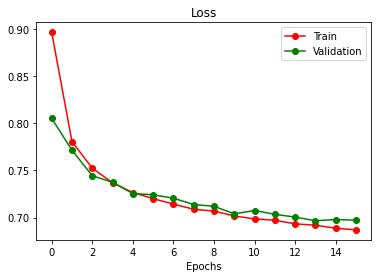

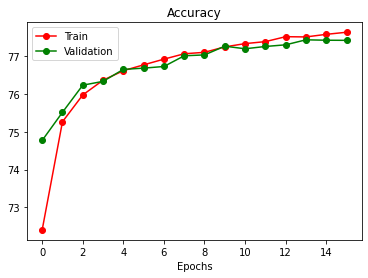

In [37]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "MultiMaskNet",
    "kernel": 5,
    "learn_rate": 0.01,
    "epochs": 16,
    "seed": 0,
    "plot": True,
    "experiment_name": "multi_mask_net_50"
}
args.update(args_dict)
cnn = train(args)